# Week 2: Tackle Overfitting with Data Augmentation

Welcome to this assignment! As in the previous week, you will be using the famous cats vs dogs dataset to train a model that can classify images of dogs from images of cats. For this, you will create your own Convolutional Neural Network in Tensorflow and leverage Keras' image preprocessing utilities, more so this time around since Keras provides excellent support for augmenting image data.

#### TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:

- All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

- You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

- You can add the comment # grade-up-to-here in any graded cell to signal the grader that it must only evaluate up to that point. This is helpful if you want to check if you are on the right track even if you are not done with the whole assignment. Be sure to remember to delete the comment afterwards!

- Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

- To submit your notebook, save it and then click on the blue submit button at the beginning of the page.

Let's get started!

In [1]:
import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp drive/MyDrive/Colab\ Notebooks/train.zip .
!unzip -q train.zip
!mkdir train/Cat train/Dog
!mv train/cat.* train/Cat
!mv train/dog.* train/Dog
!mv train PetImages

In [ ]:
import unittests

<a name="2"></a>
## Dataset exploration

You already saw this in the previous assignment but there is no harm in a quick refreshing.

Let's explore the dataset in the folder `./PetImages`. There is a subdirectory for each class, so one for dogs and one for cats. The complete tree looks like this:

```
.
└── PetImages/
    ├── Cat/
    │   ├── cat_1.jpg
    │   ├── cat_2.jpg
    │   └── ...
    └── Dog/
        ├── dog_1.jpg
        ├── dog_2.jpg
        └── ...
```

In [4]:
# Directory that holds the data
DATA_DIR = './PetImages'

# Subdirectories for each class
data_dir_dogs = os.path.join(DATA_DIR, 'Dog')
data_dir_cats = os.path.join(DATA_DIR, 'Cat')

# os.listdir returns a list containing all files under the given dir
print(f"There are {len(os.listdir(data_dir_dogs))} images of dogs.")
print(f"There are {len(os.listdir(data_dir_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


It is a good start to know how many images there are of each class but let's actually plot some of them to get a better sense of the kinds of images in the dataset:

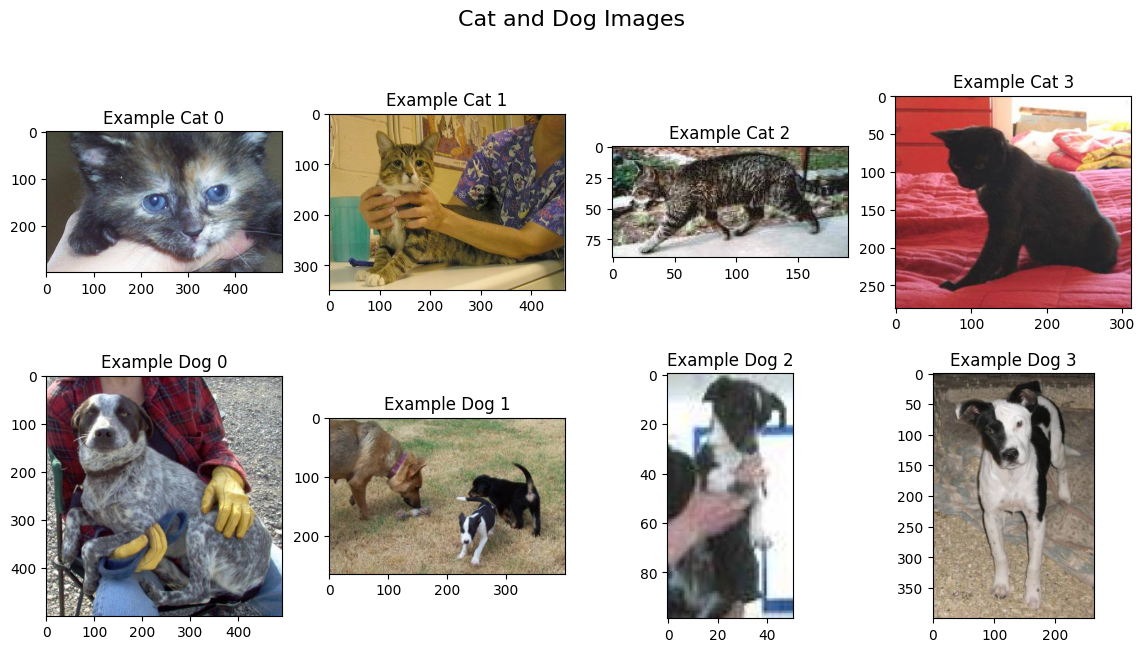

In [5]:
# Get the filenames for cats and dogs images
cats_filenames = [os.path.join(data_dir_cats, filename) for filename in os.listdir(data_dir_cats)]
dogs_filenames = [os.path.join(data_dir_dogs, filename) for filename in os.listdir(data_dir_dogs)]

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle('Cat and Dog Images', fontsize=16)

# Plot the first 4 images of each class
for i, cat_image in enumerate(cats_filenames[:4]):
    img = tf.keras.utils.load_img(cat_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Example Cat {i}')

for i, dog_image in enumerate(dogs_filenames[:4]):
    img = tf.keras.utils.load_img(dog_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Example Dog {i}')

plt.show()

These sure are cute! **Notice that these images come in all kinds of resolutions!**

<a name="ex01"></a>
## Exercise 1: train_val_datasets

Now that you are familiar with the raw data it is time for you to create the datasets that will yield batches for both for training and validation. For this, complete the `train_val_datasets` function below.


**Hints:**:

- It is recommended to read the documentation for [`tf.keras.utils.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) since this function provides a lot of functionalities.

- You should already know the directory in which the images are stored. You can either use the global variable defined earlier or hardcode the path.

- Remember that the images in this dataset come in a variety of resolutions. This can be standardized  by defining the `image_size` parameter which will be used to convert each image to this target resolution. **For this exercise, use a `image_size` of (120, 120)**. This will help with the time it takes to train the neural network compared to the previous assignment.

- It is recommended to use a `batch_size`  of 128 as it yields a good trade-off between training times and memory usage.
- You should select an appropriate value for the `label_mode` parameter given that you are dealing with binary classification.



- Since the images haven't been splitted into training and validation sets you should use the `validation_split` parameter for this purpose. **You must use 15% of the images as validation dataset**.
- When using the argument `validation_split`, there are two other arguments that **must be passed** otherwise an exception will be thrown. They are:
- - `seed`, a random seed to avoid overlapping files in training and validation (any positive integer is fine)
- - `subset`, which subset should be returned (training, validation or both). You must use the correct value given the context.


In [10]:
# GRADED FUNCTION: train_val_datasets

def train_val_datasets():
    """Creates datasets for training and validation.

    Returns:
        (tf.data.Dataset, tf.data.Dataset): Training and validation datasets.
    """

    ### START CODE HERE ###

    training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=DATA_DIR,
        image_size=(150, 150),
        batch_size=128,
        label_mode="binary",
        validation_split=0.15,
        subset="both",
        seed=42
    )

    ### END CODE HERE ###

    return training_dataset, validation_dataset

In [11]:
# Create the datasets
training_dataset, validation_dataset = train_val_datasets()

Found 25000 files belonging to 2 classes.
Using 21250 files for training.
Using 3750 files for validation.


**Expected Output:**

```
Found 22434 files belonging to 2 classes.
Using 19069 files for training.
Using 3365 files for validation.
```


In [ ]:
# Test your code!
unittests.test_train_val_datasets(train_val_datasets)

<a name="3.2"></a>
Now you have two datasets, one for training and another one for validation. In the ungraded labs you applied some extra transformations to the datasets by using methods of `tf.data.Dataset` such as [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) or [cache](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache). These help training be faster but they come at the expense of more memory usage and due to memory limitations of this environment, you will not use them in this assignment.


Before proceeding take some time to inspect a batch of the training set, you can do this using the [`take`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) method from a `tf.data.Dataset` while specifying how many batches you want to get. Using this method will yield a tuple with two elements, the first one being the images in the batch and the second one, their respective labels.

In [12]:
# Get the first batch of images and labels
for images, labels in training_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 255.0

Shape of batch of images: (128, 150, 150, 3)
Shape of batch of labels: (128, 1)


Notice that the pixel values of the images have not yet been normalized at this point so **you must add a Rescaling layer in your model, to apply a factor of 1./255 to these values.**

## Exercise 2: create_augmentation_model

With the data already in an appropriate format, your next task is to define a way to add data augmentation to the datasets, for this, complete the `create_augmentation_model` function below.

In this context you can think of a "model" as a bunch of layers stacked together. Later you will use this function to add these layers to the final model which will be trained to classify cats and dogs images. Tensorflow lets you merge models very easily since models are basically just a collection of layers!

**Hints:**

- You must NOT include the rescaling layer, i.e, [`tf.keras.layers.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) in this exercise. This function should only take care of data augmentation!

- You must include the [`tf.keras.Input`](https://www.tensorflow.org/api_docs/python/tf/keras/Input) as the first layer with the appropriate shape which is equal to the shape of each image.

- Take a look at the official TF [guide](https://www.tensorflow.org/tutorials/images/data_augmentation) on data augmentation.

- Some layers you might want to include are (but feel free to try others as well):
	- [tf.keras.layers.RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip)

	- [tf.keras.layers.RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation)
	- [tf.keras.layers.RandomTranslation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomTranslation)
	- [tf.keras.layers.RandomZoom](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom)


In [13]:
# GRADED FUNCTION: create_augmentation_model
def create_augmentation_model():
    """Creates a model (layers stacked on top of each other) for augmenting images of cats and dogs.

    Returns:
        tf.keras.Model: The model made up of the layers that will be used to augment the images of cats and dogs.
    """

    ### START CODE HERE ###

    augmentation_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(150, 150, 3)),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomTranslation(0.2, 0.2),
        tf.keras.layers.RandomZoom(0.2),
    ])

    ### END CODE HERE ###

    return augmentation_model

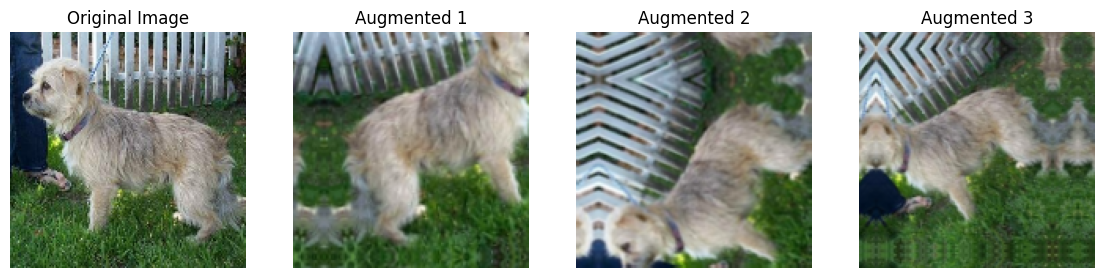

In [14]:
# Load your model for augmentation
data_augmentor = create_augmentation_model()

# Take a sample image
sample_image = tf.keras.utils.array_to_img(example_batch_images[0])

images = [sample_image]

# Apply random augmentation 3 times
for _ in range(3):
	image_aug = data_augmentor(tf.expand_dims(sample_image, axis=0))
	image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
	images.append(image_aug)


fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3']):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

**Expected Output:**
```
A figure showing the original sample image alongside 3 random versions of it with augmentation (image may vary)
```
![expected_output](https://github.com/darkknight377/tensorflow-1-public/blob/main/C2/W2/assignment/assets/output.png?raw=1)

In [ ]:
# Test your code!
unittests.test_create_augmentation_model(create_augmentation_model)

<a name="ex02"></a>
## Exercise 3: create_model

With the data ready and a way to add augmentation, your next task is to define the architecture of the model that will be trained. Complete the `create_model` function below.

Aside from defining the architecture of the model, you should also compile it so make sure to use a `loss` function that is compatible with the `label_mode` you defined in the previous exercise, which should also be compatible with the last layer of your network. You can tell if they aren't compatible if you get an error during training.

**Hints:**

- You must include the [`tf.keras.Input`](https://www.tensorflow.org/api_docs/python/tf/keras/Input) as the first layer with the appropriate shape. **This must be done even if you already defined this in the previous exercise!**

- You should use at least 3 convolution layers to achieve the desired performance. This is a necessary condition for this function to pass the grading.

- The rescaling layer, i.e, [`tf.keras.layers.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) is usually placed after the data augmentation layers.
- Remember that `tf.keras.Model`s can be stacked on top of each other since they are usually a collection of layers.
- Be mindful about the last layer and its activation function, as it will impact the loss you must use.

In [22]:
# GRADED FUNCTION: create_model

def create_model():
    """Creates the untrained model for classifying cats and dogs.

    Returns:
        tf.keras.Model: The model that will be trained to classify cats and dogs.
    """

    ### START CODE HERE ###

	# Get the augmentation layers (or model) from your earlier function
    augmentation_layers = create_augmentation_model()

	# Don't forget to add the augmentation layers! These usually go right after the Input!
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(150, 150, 3)),
        augmentation_layers,
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])


    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss=tf.keras.losses.BinaryCrossentropy,
        metrics=['accuracy']
    )

    ### END CODE HERE ###

    return model

The next cell allows you to check the number of total and trainable parameters of your model and prompts a warning in case these exceeds those of a reference solution, this serves the following 3 purposes listed in order of priority:

- Helps you prevent crashing the kernel during training.

- Helps you avoid longer-than-necessary training times.
- Provides a reasonable estimate of the size of your model. In general you will usually prefer smaller models given that they accomplish their goal successfully.

**Notice that this is just informative** and may be very well below the actual limit for size of the model necessary to crash the kernel. So even if you exceed this reference you are probably fine. However, **if the kernel crashes during training or it is taking a very long time and your model is larger than the reference, come back here and try to get the number of parameters closer to the reference.**

In [ ]:
# Create the compiled but untrained model
model = create_model()

# Check parameter count against a reference solution
unittests.parameter_count(model)

In [24]:
model = create_model()
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

Check that the architecture you used is compatible with the dataset (you can ignore the warnings prompted by using the GPU):

In [25]:
try:
	model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model.predict(example_batch_images, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (128, 1)


**Expected Output:**

```
predictions have shape: (batch_size, n_units)
```
Where `batch_size` is the one you defined and `n_units` is the number of units of the last layer of your model.

In [ ]:
# Test your code!
unittests.test_create_model(create_model)

<a name="4.2"></a>

<a name="ex03"></a>
## Exercise 4: EarlyStoppingCallback

With the model's architecture now ready, it is time for you to define a callback to stop training if the following conditions are satisfied:

- Training accuracy greater than or equal to 80%


- Validation accuracy greater than or equal to 80%

You might wonder why the training threshold to pass this assignment is significantly lower compared to last week's assignment. Image augmentation does help with overfitting but usually this comes at the expense of requiring more training time. To keep the training time reasonable, the thresholds are ajusted and your grade will be based on the fact that the model doesn't overfit.

For this, complete the `EarlyStoppingCallback` class below. Remember from course 1 that you must create a class that inherits from `tf.keras.callbacks.Callback` and you must add a method called `on_epoch_end` with the correct signature to add the stop conditions.

**Hints**:

- You may look at the documentation for [`tf.keras.callbacks.Callback`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback)


- Whenever you compile a model with a metric and provide validation data when training that model, TensorFlow will automatically create another metric and append `val_` to its name. Since your model was compiled with the `accuracy` metric and you are using a validation dataset, you will have access to a metric called `val_accuracy`


In [26]:
# GRADED CLASS: EarlyStoppingCallback

### START CODE HERE ###

# Remember to inherit from the correct class
class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    # Define the correct function signature for on_epoch_end method
    def on_epoch_end(self, epoch, logs=None):
        # Check if the accuracy is greater or equal to 0.95 and validation accuracy is greater or equal to 0.8
        if logs.get("accuracy") >= 0.80 and logs.get("accuracy") >= 0.8:
            self.model.stop_training = True

            print("\nReached 80% train accuracy and 80% validation accuracy, so cancelling training!")

### END CODE HERE ###

In [ ]:
# Test your code!
unittests.test_EarlyStoppingCallback(EarlyStoppingCallback)

<a name="5"></a>

Now it is time to train your model! The callback should fire before reaching 35 epochs, if this is not the case, try a different architecture for your model!

In [27]:
# Train the model and save the training history
# This may take up to 10-15 min so feel free to take a break! :P
history = model.fit(
	training_dataset,
	epochs=35,
	validation_data=validation_dataset,
	callbacks = [EarlyStoppingCallback()]
)

Epoch 1/35
167/167 ━━━━━━━━━━━━━━━━━━━━ 31s 164ms/step - accuracy: 0.5285 - loss: 0.6936 - val_accuracy: 0.5149 - val_loss: 0.8898
Epoch 2/35
167/167 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - accuracy: 0.6205 - loss: 0.6537 - val_accuracy: 0.5307 - val_loss: 1.1263
Epoch 3/35
167/167 ━━━━━━━━━━━━━━━━━━━━ 43s 171ms/step - accuracy: 0.6445 - loss: 0.6526 - val_accuracy: 0.5579 - val_loss: 0.8070
Epoch 4/35
167/167 ━━━━━━━━━━━━━━━━━━━━ 28s 170ms/step - accuracy: 0.6553 - loss: 0.6214 - val_accuracy: 0.7091 - val_loss: 0.5714
Epoch 5/35
167/167 ━━━━━━━━━━━━━━━━━━━━ 39s 158ms/step - accuracy: 0.6789 - loss: 0.5953 - val_accuracy: 0.6565 - val_loss: 0.6129
Epoch 6/35
167/167 ━━━━━━━━━━━━━━━━━━━━ 43s 170ms/step - accuracy: 0.6816 - loss: 0.5888 - val_accuracy: 0.5248 - val_loss: 1.1488
Epoch 7/35
167/167 ━━━━━━━━━━━━━━━━━━━━ 27s 159ms/step - accuracy: 0.6965 - loss: 0.5869 - val_accuracy: 0.7355 - val_loss: 0.5253
Epoch 8/35
167/167 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.7072 - loss: 0

<a name="5.1"></a>
Once training has finished, you can run the following cell to check the training and validation accuracy achieved at the end of each epoch.

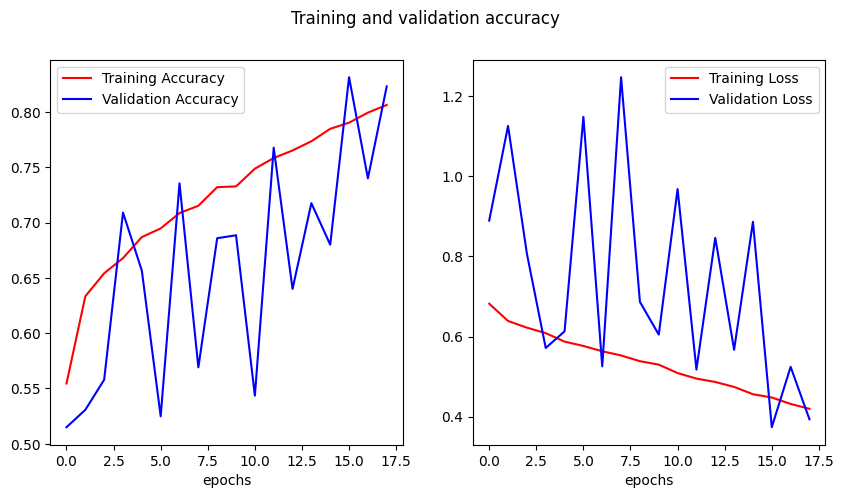

In [28]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

Unlike the previous assignment, this time the model should not be overfitting, which means that it is doing a great job at classifying the images in the training and validation sets.

**To pass this assignment your model should have achieved a training accuracy of 80% and a validation accuracy of 80% and show no signs of overfitting**.

To test the overfitting two tests will be conducted:
- The `Mean Squared Error` between your training and validation curves should be 20% at most

- The relative difference between the slopes of the training and validation curves should be 30% at most

You can run the next cell to check if these conditions are met. If your model didn't achieve these thresholds, try training again with a different model architecture and remember to use at least 3 convolutional layers.


In [ ]:
# Test your code!
unittests.test_history(history)

**Before submitting your assignment, please run the following code to save your training history as it will be used in grading.**

In [29]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

**Congratulations on finishing this week's assignment!**

You have successfully implemented a convolutional neural network that classifies images of cats and dogs without overfitting by using data augmentation techniques, along with the helper functions needed to pre-process the images!

**Keep it up!**